### 할당된 GPU 확인

In [ ]:
!nvidia-smi

Wed May 12 03:38:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


### 필요한 library 및 자료 다운로드

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 95kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 14.1MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595681 sha256=2a179e6c2ce3feda14d876b586ef614ff9792e904eee00f3710a049846ca40ae
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 14.0MB/s 
     |████████████████████████████████| 2.1MB 14.0MB/s 
     |████████████████████████████████| 901kB 59.3MB/s 
     |████████████████████████████████| 3.3MB 67.6MB/s 


In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-g6hzcsg_
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-g6hzcsg_
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12708 sha256=d9865bc0cb9ec67fff3b82a7ca3369fb089f39f2c339cf0a084a191e4b8c9d18
  Stored in directory: /tmp/pip-ephem-wheel-cache-9d2mjdyw/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab download
####vocab은 문장에 있는 단어 나눌 때 사용됨, 형태소 사전같은 걸로 생각하면 된다

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/problem_min_120.csv')

In [ ]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7, stratify = df.tag.values)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5, stratify = remaining.tag.values)

### tag가 string이기 때문에 숫자로 바꾸기 위해서 encoder라는 것을 사용한다
### encoder를 사용하면 쉽게 tag의 문자를 숫자로 바꿔준다

In [ ]:
print(train_df.shape, valid_df.shape, test_df.shape)

#라벨의 숫자화
label = df['tag'].values
encoder = LabelEncoder()
encoder.fit(label)

(916, 9) (196, 9) (197, 9)


LabelEncoder()

### label별 data 개수가 불균형한 경우 학습에 영향을 주기 때문에 loss 가중치를 조정하여 해결할 수도 있다
### 우리 학습할 땐 사용 안했음

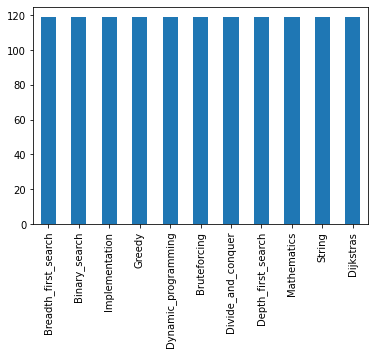

['Binary_search' 'Breadth_first_search' 'Bruteforcing'
 'Depth_first_search' 'Dijkstras' 'Divide_and_conquer'
 'Dynamic_programming' 'Greedy' 'Implementation' 'Mathematics' 'String']
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
df.tag.value_counts().plot(kind='bar')
plt.show()

class_loss = [df.tag.value_counts()[i] for i in encoder.classes_ ]
class_weights = compute_class_weight('balanced', np.unique(df['tag']), df['tag'])
weights= torch.tensor(class_weights,dtype=torch.float)
print(encoder.classes_)
print(weights)

In [ ]:
### 분류한 dataset을 형식에 맞게 변환하는 코드

In [ ]:
def set_data(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   problem = ""
   if not pd.isna(row['input']) :
     problem = problem + row['input'] 
   if not pd.isna(row['output']) :
       problem = problem + row['output']
   problem = problem + row['description']
#   if len(problem) > 0 :
#      dataset.append([problem , tmp[i]])
   dataset.append([problem , tmp[i]])
   i = i + 1
  return dataset

In [ ]:
dataset_train = set_data(train_df)
dataset_valid = set_data(valid_df)
dataset_test = set_data(test_df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


### 데이터셋 관련 코드

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [ ]:
## Setting parameters
max_len = 512
batch_size = 8
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

### 데이터 셋 표준화 과정

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

### model 할당

In [ ]:
model = BERTClassifier(bertmodel, num_classes=11, dr_rate=0.1).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

### optimizer와 loss function 설정

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
#loss_fn = nn.CrossEntropyLoss(weight = weights).to(device)
loss_fn = nn.CrossEntropyLoss()

### 잘 모르겠음 ;;

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

### 정확도 계산하는 함수

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# train 시키는 코드

In [ ]:
train_loss_values = []
validation_loss_values = [] 
train_acc_list = []
validation_acc_list = []
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_list.append(train_acc / len(train_dataloader))

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        validation_loss += loss.item() 
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)
    validation_acc_list.append(test_acc / len(valid_dataloader))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.7913577556610107 train acc 0.375

epoch 1 train acc 0.29891304347826086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.25


epoch 2 batch id 1 loss 1.9271925687789917 train acc 0.25

epoch 2 train acc 0.3076086956521739



epoch 2 test acc 0.24


epoch 3 batch id 1 loss 1.8107010126113892 train acc 0.25

epoch 3 train acc 0.3173913043478261



epoch 3 test acc 0.225


epoch 4 batch id 1 loss 1.8249726295471191 train acc 0.375

epoch 4 train acc 0.325



epoch 4 test acc 0.23


epoch 5 batch id 1 loss 1.8572100400924683 train acc 0.375

epoch 5 train acc 0.31956521739130433



epoch 5 test acc 0.23


epoch 6 batch id 1 loss 1.7012027502059937 train acc 0.25

epoch 6 train acc 0.3



epoch 6 test acc 0.24


epoch 7 batch id 1 loss 1.694284439086914 train acc 0.25

epoch 7 train acc 0.3141304347826087



epoch 7 test acc 0.23


epoch 8 batch id 1 loss 1.5194979906082153 train acc 0.25

epoch 8 train acc 0.3108695652173913



epoch 8 test acc 0.245


epoch 9 batch id 1 loss 1.7177433967590332 train acc 0.375

epoch 9 train acc 0.3217391304347826



epoch 9 test acc 0.235


epoch 10 batch id 1 loss 1.5867255926132202 train acc 0.25

epoch 10 train acc 0.32065217391304346



epoch 10 test acc 0.2


### loss graph 그린다

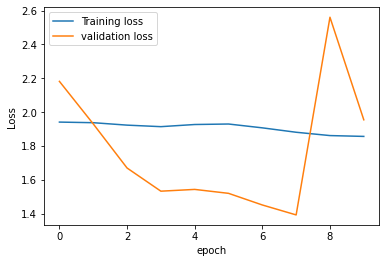

In [ ]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 정확도 graph 그림

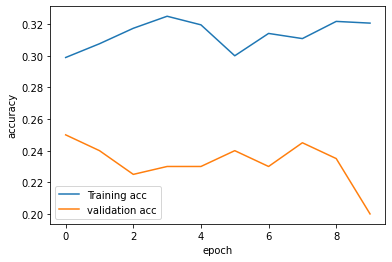

In [ ]:
plt.plot(np.array(train_acc_list), label='Training acc')
plt.plot(np.array(validation_acc_list), label='validation acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### predict하는 코드

In [ ]:
pred_list = []
test_label = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    test_label.append(label)
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
#    out = model2(token_ids, valid_length, segment_ids)
    _, pred_value = torch.max(out, 1)
    pred_list.append(pred_value.cpu().numpy())

pred_list = [a.squeeze().tolist() for a in pred_list]
test_label = [a.squeeze().tolist() for a in test_label]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 알고리즘별 정확도 출력하는 코드
#### precision : label이 a일 때 a라고 예측한 확률
#### recall : a라고 예측했을 때, a인 확률
#### f1-score : recall과 precision의 조화평균
#### support : 개수
#### 관점에 따라 사용하는 것이 다르다고 생각하면 됨 

In [ ]:
target_name = encoder.classes_
print(classification_report(test_label, pred_list, target_names=target_name, zero_division = 0))

                      precision    recall  f1-score   support

       Binary_search       0.00      0.00      0.00        18
Breadth_first_search       0.00      0.00      0.00        18
        Bruteforcing       0.00      0.00      0.00        18
  Depth_first_search       0.11      0.67      0.19        18
           Dijkstras       0.00      0.00      0.00        18
  Divide_and_conquer       0.18      0.11      0.14        18
 Dynamic_programming       0.25      0.06      0.09        18
              Greedy       0.18      0.11      0.14        18
      Implementation       0.22      0.22      0.22        18
         Mathematics       0.32      0.39      0.35        18
              String       0.50      0.47      0.48        17

            accuracy                           0.18       197
           macro avg       0.16      0.18      0.15       197
        weighted avg       0.16      0.18      0.14       197



### test data에서 맞은 지문과 틀린 지문을 나누어 저장하기 위한 코드

In [ ]:
def extract_false(dataframe, pred_list) :
  i = 0
  false_list = []
  col_name = ['id', 'description', 'input', 'output', 'true', 'prediction']
  for index, row in dataframe.iterrows():
    if pred_list[i] != row['tag'] :
      false_list.append([row['id'], row['description'], row['input'], row['output'], 
                         row['tag'], pred_list[i]])
    i = i + 1
  df = pd.DataFrame(false_list, columns = col_name)
  return df

def extract_true(dataframe, pred_list) :
  i = 0
  false_list = []
  col_name = ['id', 'description', 'input', 'output', 'true', 'prediction']
  for index, row in dataframe.iterrows():
    if pred_list[i] == row['tag'] :
      false_list.append([row['id'], row['description'], row['input'], row['output'], 
                         row['tag'], pred_list[i]])
    i = i + 1
  df = pd.DataFrame(false_list, columns = col_name)
  return df


In [ ]:
"""
pl = encoder.inverse_transform(pred_list)

false_df = extract_false(test_df, pl)
true_df = extract_true(test_df, pl)
false_df.to_csv('/content/drive/MyDrive/false_prediction_120.csv', encoding='utf-8-sig')
true_df.to_csv('/content/drive/MyDrive/true_prediction_120.csv', encoding='utf-8-sig')
"""

"\npl = encoder.inverse_transform(pred_list)\n\nfalse_df = extract_false(test_df, pl)\ntrue_df = extract_true(test_df, pl)\nfalse_df.to_csv('/content/drive/MyDrive/false_prediction_120.csv', encoding='utf-8-sig')\ntrue_df.to_csv('/content/drive/MyDrive/true_prediction_120.csv', encoding='utf-8-sig')\n"

### y축 = input x축 = 예측 결과, 대각선의 확률이 a일 때 a로 예측한 확률

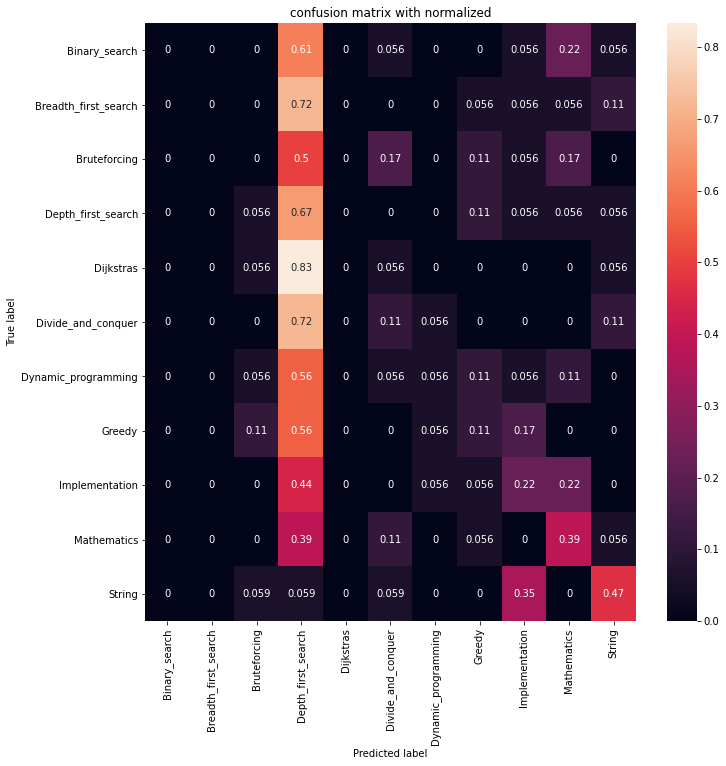

In [ ]:
cm = confusion_matrix(test_label, pred_list)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, target_name, target_name)
plt.figure(figsize=(11, 11))
plt.title('confusion matrix with normalized')
sn.heatmap(df_cm, annot = True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 학습한 모델 저장하기 위한 코드

In [ ]:
import os

save_dir = '/content/drive/MyDrive/model_save/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#save_name = save_dir + 'bert.pt'
save_name = save_dir + 'aug_bert.pt'

def save(model, optimizer, file):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, file)


In [ ]:
#save(model, optimizer, save_name)

### load model

In [ ]:
"""
checkpoint = torch.load(save_name, map_location='cpu')

model2 = BERTClassifier(bertmodel, num_classes=11, dr_rate=0.2).to(device)
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
"""

"\ncheckpoint = torch.load(save_name, map_location='cpu')\n\nmodel2 = BERTClassifier(bertmodel, num_classes=11, dr_rate=0.2).to(device)\nmodel2.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\n"